In [1]:
import numpy as np
from scipy.integrate import odeint

# Exploring Drag/Damping in Reservoir Computers

Let's start with a 1D system:
$$\frac{dr}{dt} = F(r, u, d, t) = \gamma \big[-r + \tanh\big(\rho r(t) + \sigma u(t) + \delta v(t)\big) \big]$$
Where $u$ is the training signal, $v$ is the input to the system and $\gamma, \rho, \sigma, \delta$ are parameters.

Let's compute the second derivative,
$$ \frac{d^2r}{dt^2} = \frac{dF}{dt}(r,u, d, t) = \gamma\big[-\frac{dr}{dt} + sech^2\big(\rho r(t) + \sigma u(t) + \delta v(t)\big) \big(\rho \frac{dr}{dt} + \sigma \frac{du}{dt} + \delta \frac{dv}{dt}\big)\big]$$

and add damping to create a new system:
\begin{align}  
\frac{d^2s}{dt^2} &= \frac{dF}{dt}(s,u, d, t) + \alpha \frac{ds}{dt} \\
&=  \gamma\big[-\frac{ds}{dt} + sech^2\big(\rho s(t) + \sigma u(t) + \delta v(t)\big) \big(\rho \frac{ds}{dt} + \sigma \frac{du}{dt} + \delta \frac{dv}{dt}\big)\big] - \alpha \frac{ds}{dt} 
\end{align}
however, we can integrate this system with respect to time, producing
\begin{align}
\int \frac{d^2s}{dt^2} dt &= \int \frac{dF}{dt}(s,u, d, t) - \alpha \frac{ds}{dt} dt \\
\frac{ds}{dt} &= F(s, u, d, t) - \alpha s + c
\end{align}

If I did the integral correctly, this appears to be the same as:
\begin{align}
\frac{ds}{dt} &= F(s, u, d, t) - \alpha s + c \\
&= \gamma \big[-r + \tanh\big(\rho r(t) + \sigma u(t) + \delta v(t)\big) \big] - \alpha s + c \\
&= -(\gamma + \alpha) r + \gamma \tanh\big(\rho r(t) + \sigma u(t) + \delta v(t)\big) + c
\end{align}

Since $\alpha$ can be any value we want, this is the same as adding an extra degree of freedom to the system by adding another hyper parameter. If we let $c = 0$ (And I'm not sure if we can do that), then an equivalent system to the system above can be obtained with only a minor modification, $\beta = \alpha + \gamma$:

$$\frac{ds}{dt} = -\beta s + \gamma \tanh\big(\rho s(t) + \sigma u(t) + \delta v(t)\big)$$

This is easilly generalized to an $n_r$ dimensional reservoir, a $n_u$ dimensional training data and a $n_v$ dimensional input via
$$\frac{d\mathbf{r}}{dt} = -\beta \mathbf{r} + \gamma \tanh\big(A \mathbf{r} + \sigma W_\text{in}\mathbf{u} + \delta W_\text{drive}\mathbf{v}\big)$$

Where $A$ is an $(n_r \times n_r)$ matrix, $W_\text{in}$ is $(n_r \times n_u)$ and $W_\text{drive}$ is $(n_r \times n_v)$

If my math is right, this would be a lot easier to work with computationally and would only require a very simple change to the code we already have.

### Modify driven reservoir computer

In [4]:
import rescomp as rc

class DragResComp(rc.DrivenResComp):
    def __init__(self, *args, beta=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.beta = beta

    def res_f(self, t, r, u, d):
        """ ODE to drive the reservoir node states with u(t) and a input signal d(t)"""
        transform_train = self.sigma * self.W_in @ u(t)
        transform_drive = self.delta * self.W_drive @ d(t)
        return -1 * self.beta * r + self.gamma*self.activ_f(self.res @ r + transform_train + transform_drive)

    def res_pred_f(self, t, r, d):
        """ Reservoir prediction ode. Assumes precomputed W_out. Accepts an input signal d(t) """
        recurrence = self.sigma * self.W_in @ (self.W_out @ r)
        transform_drive =  self.delta * self.W_drive @ d(t)
        return -1*self.beta*r + self.gamma*self.activ_f(self.res @ r + recurrence + transform_drive)      

### Load Soft Robot Data

In [9]:
from scipy.io import loadmat
from matplotlib import pyplot as plt

def load_robo(filename):
    """Load soft robot data"""
    data = loadmat(filename)
    t = data['t'][0]
    q = data['q']
    pref = data["pref"]
    return t, q, pref

t, q, pref = load_robo("../Data/bellows_arm1_whitened.mat")
N = 100_000
M = 5_000
t_train, t_test = t[:N], t[N:N+M]
U_train, U_test = q[:N], q[N:N+M]
D_train, D_test = pref[:N], pref[N:N+M]

### Example using the old system

In [10]:
# Our old best hyper parameters
SOFTROBO_PRIOR = {
    'delta': 0.3736117214,
    'gamma': 18.66636932,
    'mean_degree': 1.7242465519999999,
    'ridge_alpha': 1.268554237,
    'sigma': 0.3125062064,
    'spect_rad': 0.8922393143999999,
}

# Create values for the new hyper parameter
alpha = 0
beta = alpha + SOFTROBO_PRIOR["gamma"]

# Initialize the reservoir computer
dragrc = DragResComp(beta=beta, signal_dim=6, drive_dim=6, **SOFTROBO_PRIOR)

In [17]:
dragrc.train(t_train, U_train, D_train, window=0.5, overlap=0)
r0 = dragrc.r0
Uhat = dragrc.predict(t_test, D_test, r0=r0)

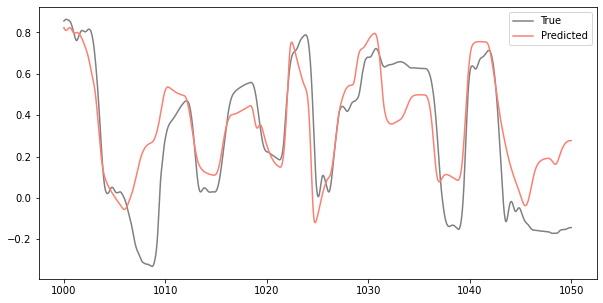

In [19]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(t_test, U_test[:,0], c="grey", label="True")
plt.plot(t_test, Uhat[:,0], c="salmon", label="Predicted")
plt.legend()
plt.show()

### Increase damping

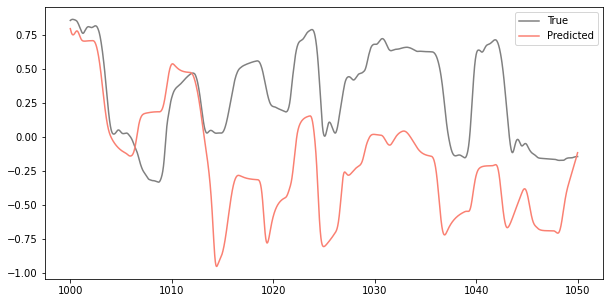

In [22]:
# Create values for the new hyper parameter
alpha = 10.0
beta = alpha + SOFTROBO_PRIOR["gamma"]

# Initialize the reservoir computer
dragrc = DragResComp(beta=beta, signal_dim=6, drive_dim=6, **SOFTROBO_PRIOR)

# Train 
dragrc.train(t_train, U_train, D_train, window=0.5, overlap=0)
r0 = dragrc.r0
Uhat = dragrc.predict(t_test, D_test, r0=r0)

plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(t_test, U_test[:,0], c="grey", label="True")
plt.plot(t_test, Uhat[:,0], c="salmon", label="Predicted")
plt.legend()
plt.show()

### Decrease Damping

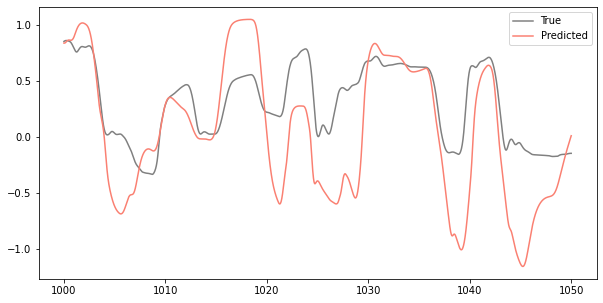

In [23]:
# Create values for the new hyper parameter
alpha = -10.0
beta = alpha + SOFTROBO_PRIOR["gamma"]

# Initialize the reservoir computer
dragrc = DragResComp(beta=beta, signal_dim=6, drive_dim=6, **SOFTROBO_PRIOR)

# Train 
dragrc.train(t_train, U_train, D_train, window=0.5, overlap=0)
r0 = dragrc.r0
Uhat = dragrc.predict(t_test, D_test, r0=r0)

plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(t_test, U_test[:,0], c="grey", label="True")
plt.plot(t_test, Uhat[:,0], c="salmon", label="Predicted")
plt.legend()
plt.show()